In [1]:
options(repr.plot.width  = 15, repr.plot.height = 10)

# Libraries

In [2]:
# Helper packages
library(dplyr)       # for data wrangling
library(ggplot2)     # for awesome plotting
library(doParallel)  # for parallel backend to foreach
library(foreach)     # for parallel processing with for loops

# Modeling packages
library(caret)       # for general model fitting
library(recipes)
library(rpart)       # for fitting decision trees
library(ipred)       # for fittinf bagging model



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel

Loading required package: lattice


Attaching package: ‘recipes’


The following object is masked from ‘package:stats’:

    step




In [3]:
rmse <- function(pred, obs){
    sqrt(mean((obs-pred)^2))
}

# Load Data|

In [4]:
ames <- AmesHousing::make_ames()

# Split Datasets

In [5]:
set.seed(123)
index_train <- createDataPartition(ames$Sale_Price, p = 0.8, 
                               list = FALSE, )
index_train  <- as.vector(index_train)

house_train <- ames[index_train, ]
house_test  <- ames[-index_train, ]

# Preprocessing

In [6]:
# log transformation
blueprint_house <- recipe(Sale_Price ~ ., data = house_train) %>%
  step_nzv(all_nominal()) %>%
  step_integer(matches("Qual|Cond|QC|Qu")) %>%
  step_center(all_numeric(), -all_outcomes()) %>%
  step_scale(all_numeric(), -all_outcomes()) %>%
  step_dummy(all_nominal(), -all_outcomes(), one_hot = TRUE)

prepare <- prep(blueprint_house, training = house_train)
baked_train <- bake(prepare, new_data = house_train)
baked_test <- bake(prepare, new_data = house_test)


# Modeling

## KNN
Podemos usar la implementación que usa caret de KNN para usarlo en nuestro modelo de bagging custom.

### knnreg
knnreg(formula, k = 5, data)

### Challenge
Crear desde 0 bagging usando knn como *base learner*, para ello tienen que realizar las siguientes tareas
* Definir el parámetro k para el base learner
* Definir el número de estimadores
* Crear una lista para almacenar los estimadores
* TRAIN: Iterar sobre el número de estimadores y en cada uno de ellos
  * hacer un bootstrapping del dataset => sample(1:n_samples, n_samples, replace=TRUE)
  * crear un modelo knnreg con esa data y el valor de **k**
  * guardar el modelo en la lista de estimadores
* TEST: Crear una función que devuelve el promedio de las predicciones para cada uno de los estimadores. Los argumentos de entrada de la función son la lista de los modelos y el dataset a evaluar.
  * crear un vector para almacenar los resultados acumulados de la predicción.
  * Iterar por cada modelo, hacer la predicción del dataset y guardar el resultado en el vector de resultado (+=)
  * Dividir el resultado acumulado por el número de estimadores (respuesta promedio)
  * devolver el promedio de las respuestas
* Evaluar el resultado para train y test (rmse)


In [7]:
k = 2
n_models = 10
knn_ensamble = list()

n_samples = nrow(baked_train)
n_unique_saples = rep(0, n_models)
oob = 0
#set.seed(123)
for(i in 1:n_models) {
   index = sample(1:n_samples, n_samples, replace = TRUE)
   n_unique_saples[i] = length(unique(index))/n_samples
   near = knnreg(Sale_Price ~ ., data = baked_train[index,], k = k)
   knn_ensamble[[i]] = near
   oob = oob + rmse(predict(near, baked_train[-index,]), baked_train[-index,]$Sale_Price)
}
oob = oob / n_models
paste('oob: ', oob)

[1] "oob:  38619.5052242625"

In [8]:
# proporcion de los valores unicos de la muestra
summary(n_unique_saples)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6223  0.6265  0.6302  0.6298  0.6325  0.6368 

In [9]:
knn_ensamble_predict <- function(n_models, data){
    accumulated_result  <- matrix(0, nrow = nrow(data))
    for(model in n_models) {
       accumulated_result = accumulated_result + predict(model, data) 
    }
    accumulated_result = accumulated_result/length(n_models)
    
    accumulated_result
}

In [10]:
data_eval = baked_train
predict = knn_ensamble_predict(knn_ensamble, data_eval)
rmse(pred = predict, obs = data_eval$Sale_Price)

[1] 20543.19

In [11]:
data_eval = baked_test
predict = knn_ensamble_predict(knn_ensamble, data_eval)
rmse(pred = predict, obs = data_eval$Sale_Price)

[1] 33354.5

## Bagging

La funcion **bagging()** es parte de la librería [ipred]() y es usada para hacer bagging con cualquier modelo que queramos.
* nbag: controla el número de *base learners* number of bootstrap replications. 

Dado que el *base learner* es unico y en el caso generico de bagging usa un rpart (tree) podemos controlar los hiper-parametros del arbol para lograr el mejor resultado. Una de las cosas que hacer rpart de manera automatica es hacer *pruning* el con parametro *cp* el cual controla que el árbol tenga baja varianza y no haga overfitting, sin embargo lo que nosotros buscamos es eso, para ello dejaremos el parámetro **cp=0**.


In [12]:
set.seed(123)

# train bagged model
house_bag <- bagging(
  formula = Sale_Price ~ .,
  data = house_train,
  nbagg = 100,  
  coob = TRUE,
  control = rpart.control(minsplit = 2, cp = 0)
)

house_bag


Bagging regression trees with 100 bootstrap replications 

Call: bagging.data.frame(formula = Sale_Price ~ ., data = house_train, 
    nbagg = 100, coob = TRUE, control = rpart.control(minsplit = 2, 
        cp = 0))

Out-of-bag estimate of root mean squared error:  25827.41 


In [13]:
data_eval = house_train
predict_bag = predict(house_bag, data_eval)
rmse(pred = predict_bag, obs = data_eval$Sale_Price)

[1] 9711.042

In [14]:
data_eval = house_test
predict_bag = predict(house_bag, data_eval)
rmse(pred = predict_bag, obs = data_eval$Sale_Price)

[1] 24878.06

### Caret Bagging tree
La librería ipred no nos permite calcular las importancia de las variables, pero caret si. Para ello entrenamos un modelo de bagging con árboles y usamos la librería vip para ver la importancia de cada una de las variables.

Similar a como se obtenía la importancia en los árboles de decisión (suma acumulada de la reducción del sse o IG) en bagging se usa el mismo concepto por como el promedio de todos los estimadores, esto nos da una el promedio de importancia de las variables.



In [15]:
house_bag_caret <- train(
  Sale_Price ~ .,
  data = house_train,
  method = "treebag",
  trControl = trainControl(method = "cv", number = 3),
  nbagg = 200,  
  control = rpart.control(minsplit = 2, cp = 0)
)
house_bag_caret

Bagged CART 

2346 samples
  80 predictor

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 1565, 1563, 1564 
Resampling results:

  RMSE      Rsquared   MAE     
  31010.01  0.8535611  17576.82


In [16]:
data_eval = house_train
predict_bag = predict(house_bag_caret, data_eval)
rmse(pred = predict_bag, obs = data_eval$Sale_Price)

[1] 9880.886

In [17]:
data_eval = house_test
predict_bag = predict(house_bag_caret, data_eval)
rmse(pred = predict_bag, obs = data_eval$Sale_Price)

[1] 27302.02

Una de las diferencias con usar simplemente árboles es que ahora hay más variables que ganan importancia (pequeña pero diferente de cero) esto debido a que todos los árboles reciben información diferente.

Warning message in vip.default(house_bag_caret, num_features = 40, bar = FALSE):
“The `bar` argument has been deprecated in favor of the new `geom` argument. It will be removed in version 0.3.0.”


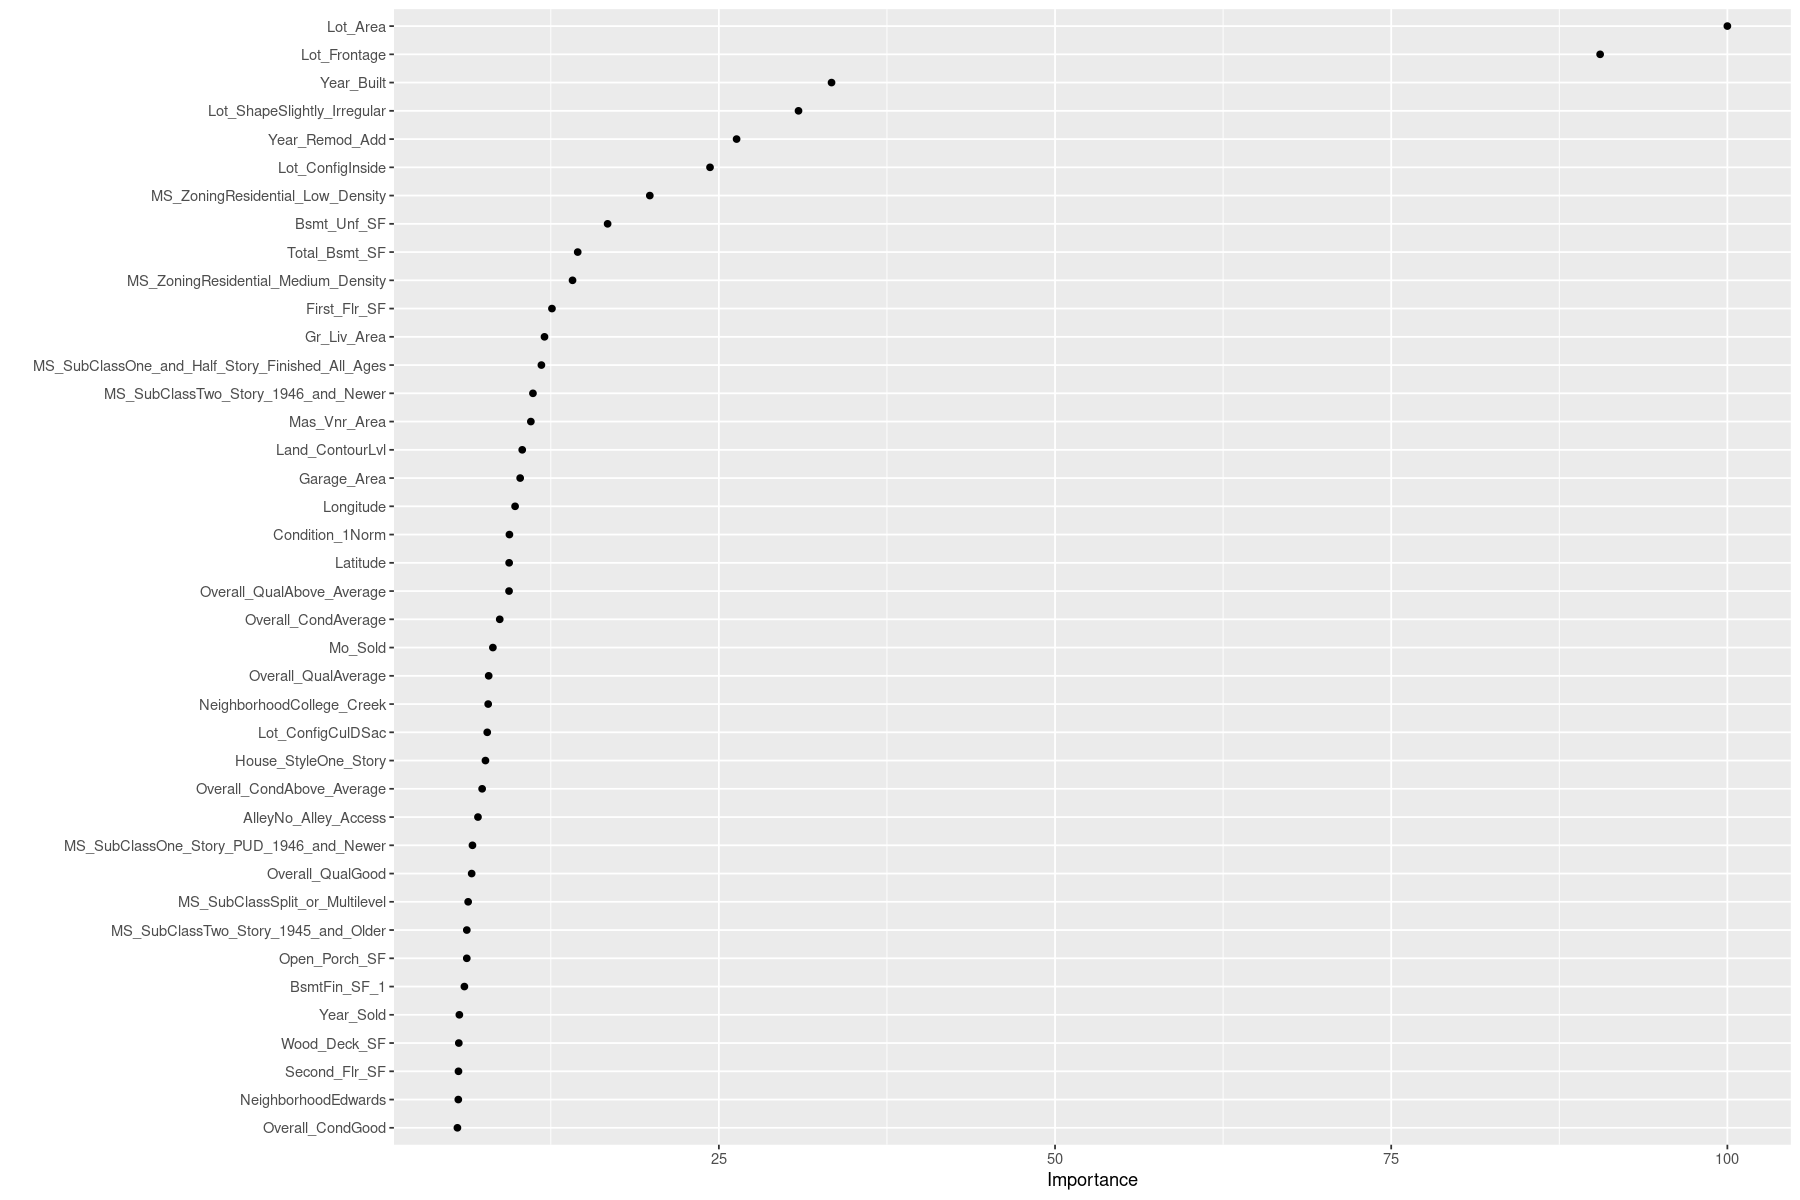

In [18]:
vip::vip(house_bag_caret, num_features = 40, bar = FALSE)